In [10]:
%config Completer.use_jedi = False

In [11]:
from utils import *
import numpy as np
import random
import pandas as pd
import scipy
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

dataset = "../datasets/UK50_1.txt"
meta_data, distance_data, station_data = parse_UK_Data(dataset)

#station_coordinates = generate_coordinates(station_data, to_csv=True, filename=dataset)
location_context = "United Kingdom"
#station_coordinates = generate_coordinates(station_data,location_context,to_csv=True,filename=dataset)
station_coordinates = pd.read_csv('../datasets/UK50_1_coordinates.csv', encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()

meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000
starts =[0,6,10,15]
vehicle_amount = len(starts)
ends = [4,2,25,30]
#distance_matrix_here,time_matrix_here,_ = generate_large_distance_matrix(points_coordinate,api)
distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/",dataset)
customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[starts] = 0
customer_demands[ends] = 0


In [94]:
niu_constants_light_vehicle = {
    "fuel_to_air_ratio":1,
    "g":9.81,
    "air_density": 1.2041,
    "frontal_surface_area": 7.5,
    "rolling_resistance": 0.01,
    "aerodynamics_drag": 0.7,
    "conversion_factor":737,
    "heating_value":44,
    "vehicle_drive_train": 0.4,
    "efficiency_diesel":0.9,
    "engine_friction": 0.2,
    "engine_speed": 33,
    "engine_displacement": 5
    
}
# Angle to ground is constantly assumed to be 0
niu_constants_light_vehicle["alpha"] = niu_constants_light_vehicle["g"] * niu_constants_light_vehicle["rolling_resistance"]

niu_constants_light_vehicle["lambda"] = niu_constants_light_vehicle["fuel_to_air_ratio"]/(niu_constants_light_vehicle["heating_value"]*niu_constants_light_vehicle["conversion_factor"])

niu_constants_light_vehicle["gamma"] = niu_constants_light_vehicle["efficiency_diesel"]/(1000*niu_constants_light_vehicle["vehicle_drive_train"])

niu_constants_light_vehicle["beta"] = 0.5* niu_constants_light_vehicle["aerodynamics_drag"]  * niu_constants_light_vehicle["frontal_surface_area"]  * niu_constants_light_vehicle["air_density"] 

In [95]:
def fuel_consumption_rauniyar(from_node,to_node,distance_matrix,time_matrix,demands,vehicle_weight,start_positions):
    distance = distance_matrix.iloc[from_node][to_node]
    
    demand = 0 if from_node in start_positions else demands[from_node]
    
    current_speed = distance/time_matrix.iloc[from_node][to_node]

    curb_weight =  demand + vehicle_weight

    first_term = (niu_constants_light_vehicle["engine_friction"] * niu_constants_light_vehicle["engine_speed"] * niu_constants_light_vehicle["engine_displacement"] * distance)/current_speed

    second_term = curb_weight * niu_constants_light_vehicle["gamma"] * niu_constants_light_vehicle["alpha"]*distance
    
    third_term = niu_constants_light_vehicle["beta"] * niu_constants_light_vehicle["gamma"] * distance * (current_speed**2)
    
    fuel_consumption = niu_constants_light_vehicle["lambda"] * (first_term + second_term + third_term)

    
    return fuel_consumption

# Create helper functions

In [103]:
def get_route_fuel_and_distances(route,start_positions,end_positions,distance_matrix,time_matrix,vehicle_empty_weight,demands,meta_data,cumulative_load=True):
    route_distances = []
    route_times = []
    route_fuel_consumptions_wong = []
    route_fuel_consumptions_linear = []
    vehicle_load = 0
    for index in range(len(route) - 1):
        from_node = route[index]
        to_node = route[index+1]
        route_distances.append(distance_matrix.iloc[from_node][to_node])
        route_times.append(time_matrix.iloc[from_node][to_node])
        
#         route_fuel_consumptions_linear.append(fuel_consumption_linear(from_node=from_node,to_node=to_node,
#                                                                     distance_matrix=distance_matrix,demands=demands,
#                                                                     cumulative_route_load=vehicle_load,meta_data=meta_data))
        
        route_fuel_consumptions_linear.append(fuel_consumption_rauniyar(from_node=from_node,to_node=to_node,
                                                                 distance_matrix=distance_matrix,time_matrix=time_matrix,
                                                                 demands=demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                 start_positions=start_positions))
        
        route_fuel_consumptions_wong.append(fuel_consumption_wong(from_node=from_node,to_node=to_node,
                                                                 distance_matrix=distance_matrix,time_matrix=time_matrix,
                                                                 demands=demands,vehicle_weight = vehicle_empty_weight + vehicle_load,
                                                                 start_positions=start_positions,meta_data=meta_data))
        if cumulative_load:
            vehicle_load += demands[from_node]
                
    return route_distances,route_times,route_fuel_consumptions_wong,route_fuel_consumptions_linear
    
def generate_routes(amount_of_routes,amount_of_nodes,start_positions,end_positions):
    return_routes = []
    random.seed(0)
    nodes = list((set(range(amount_of_nodes)) - set(start_positions)) - set(end_positions))
    
    for x in range(amount_of_routes):
        route_nodes = random.sample(nodes,random.randint(1,len(nodes)))
        start_node = random.choice(start_positions)
        end_node = random.choice(end_positions)
        route_nodes.insert(start_node,0)
        route_nodes.append(end_node)
        return_routes.append(route_nodes)
    return return_routes
    

# Gather correlation data

In [104]:
route_amount= 500
test_routes = generate_routes(route_amount,len(customer_demands),starts,ends)
test_routes_distances = []
test_routes_times = []
test_routes_fuel_consumptions_wong = []
test_routes_fuel_consumptions_linear = []
test_distance_wong_correlations = []
test_distance_linear_correlations = []
test_distance_wong_pearson = []
test_distance_linear_pearson = []


test_routes_distances_cumulative = []
test_routes_fuel_consumptions_wong_cumulative = []
test_routes_fuel_consumptions_linear_cumulative = []
test_distance_wong_correlations_cumulative = []
test_distance_linear_correlations_cumulative = []
test_distance_wong_pearson_cumulative = []
test_distance_linear_pearson_cumulative = []
test_times_wong_correlation_cumulative = []

for index in tqdm(range(0,len(test_routes))):
    route = test_routes[index]
    distances,times,fuel_wong,fuel_linear = get_route_fuel_and_distances(route,starts,ends,distance_matrix_here,time_matrix_here,3000,customer_demands,meta_data,cumulative_load=False)
    test_routes_distances.append(distances)
    test_routes_fuel_consumptions_wong.append(fuel_wong)
    test_routes_fuel_consumptions_linear.append(fuel_linear)
    

    test_distance_wong_correlations.append([len(distances),np.corrcoef(distances,fuel_wong)[0][1]])
    test_distance_linear_correlations.append([len(distances),np.corrcoef(distances,fuel_linear)[0][1]])
    test_distance_wong_pearson.append([len(distances),pearsonr(distances,fuel_wong)[0]])
    test_distance_linear_pearson.append([len(distances),pearsonr(distances,fuel_linear)[0]])
    
    
    
    distances,times,fuel_wong,fuel_linear = get_route_fuel_and_distances(route,starts,ends,distance_matrix_here,time_matrix_here,3000,customer_demands,meta_data)
    test_routes_distances_cumulative.append(distances)
    test_routes_fuel_consumptions_wong_cumulative.append(fuel_wong)
    test_routes_fuel_consumptions_linear_cumulative.append(fuel_linear)
    test_distance_wong_correlations_cumulative.append([len(distances),np.corrcoef(distances,fuel_wong)[0][1]])
    test_distance_linear_correlations_cumulative.append([len(distances),np.corrcoef(distances,fuel_linear)[0][1]])
    test_distance_wong_pearson_cumulative.append([len(distances),pearsonr(distances,fuel_wong)[0]])
    test_distance_linear_pearson_cumulative.append([len(distances),pearsonr(distances,fuel_linear)[0]])
    test_times_wong_correlation_cumulative.append([len(times),np.corrcoef(times,fuel_wong)[0][1]])
    

  0%|          | 0/500 [00:00<?, ?it/s]

# Plot results

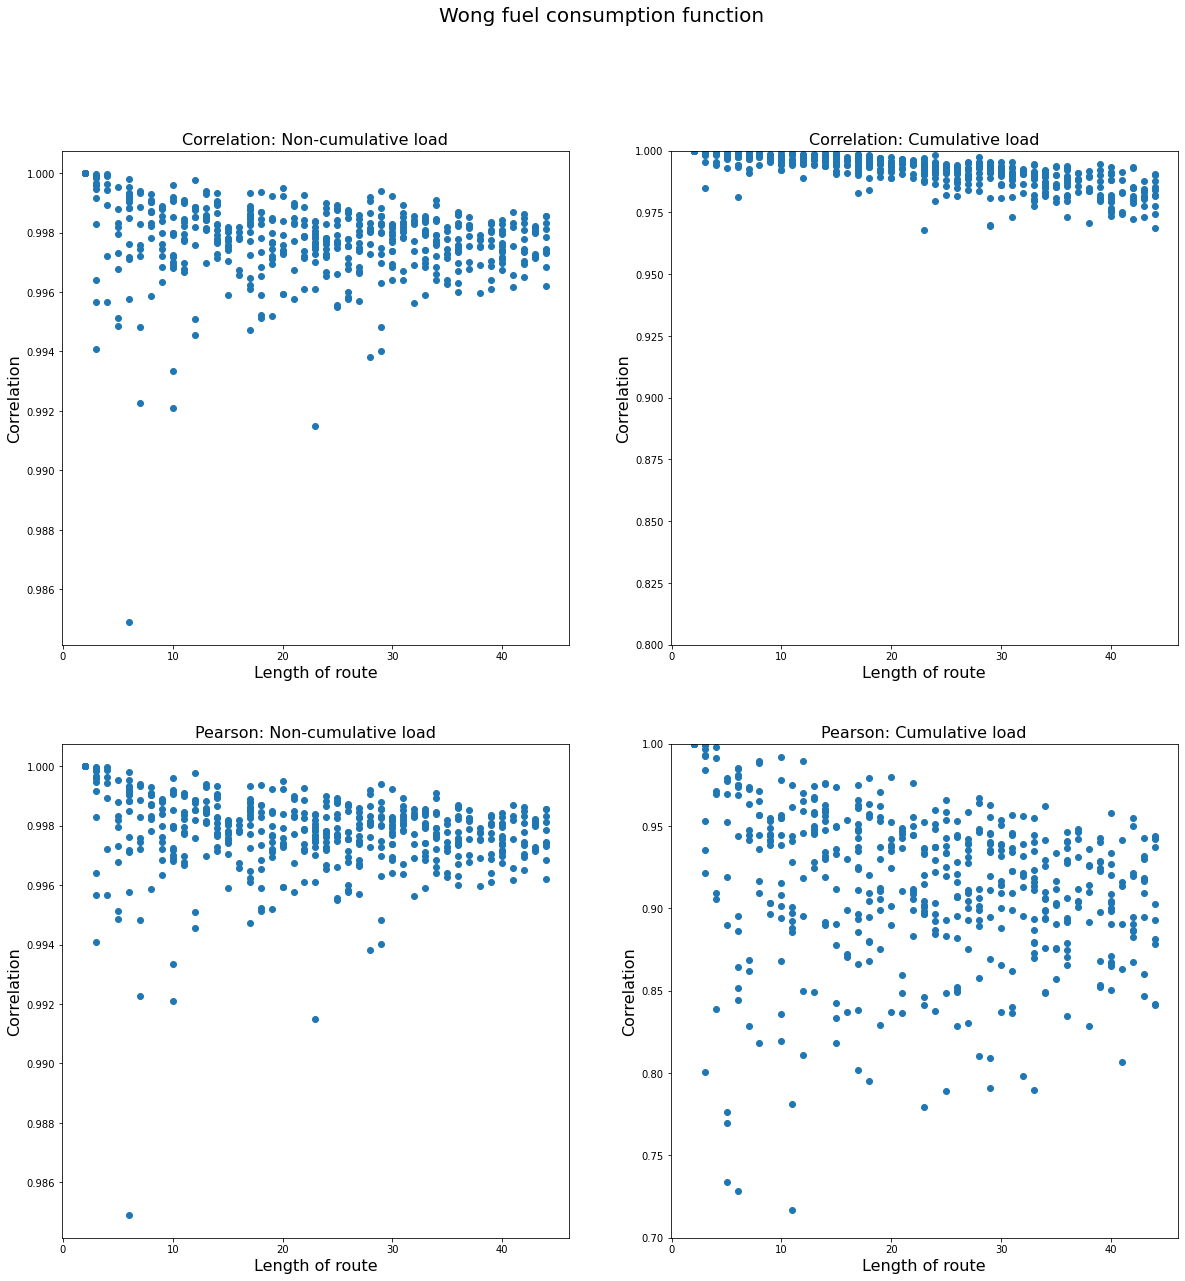

In [110]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axs[0][0].scatter(np.array(test_distance_wong_correlations)[:,0],np.array(test_distance_wong_correlations)[:,1])
axs[0][0].set_title("Correlation: Non-cumulative load",fontsize=16)
axs[0][0].set_ylabel("Correlation",fontsize=16)
axs[0][0].set_xlabel("Length of route",fontsize=16)


axs[0][1].scatter(np.array(test_distance_wong_correlations_cumulative)[:,0],np.array(test_distance_wong_correlations_cumulative)[:,1])
axs[0][1].set_title("Correlation: Cumulative load",fontsize=16)
axs[0][1].set_ylabel("Correlation",fontsize=16)
axs[0][1].set_xlabel("Length of route",fontsize=16)
axs[0][1].set_ylim(0.8,1)

axs[1][0].scatter(np.array(test_distance_wong_pearson)[:,0],np.array(test_distance_wong_pearson)[:,1])
axs[1][0].set_title("Pearson: Non-cumulative load",fontsize=16)
axs[1][0].set_ylabel("Correlation",fontsize=16)
axs[1][0].set_xlabel("Length of route",fontsize=16)

axs[1][1].scatter(np.array(test_times_wong_correlation_cumulative)[:,0],np.array(test_times_wong_correlation_cumulative)[:,1])
axs[1][1].set_title("Pearson: Cumulative load",fontsize=16)
axs[1][1].set_ylabel("Correlation",fontsize=16)
axs[1][1].set_xlabel("Length of route",fontsize=16)
axs[1][1].set_ylim(0.7,1)
plt.suptitle("Wong fuel consumption function",fontsize=20)
plt.show()

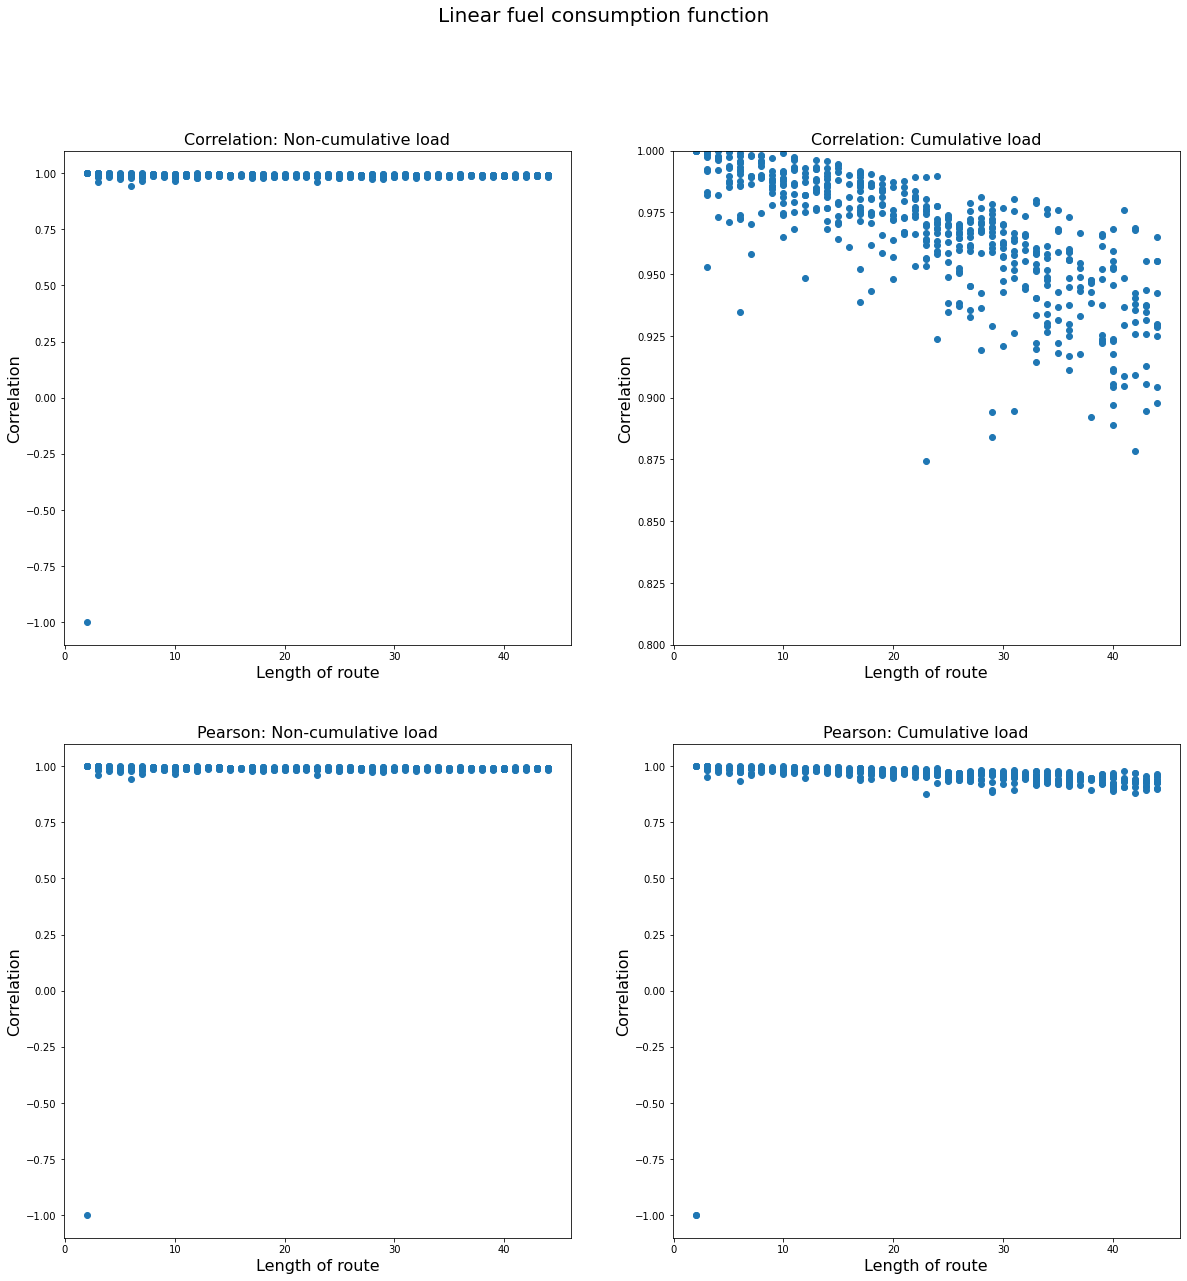

In [106]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axs[0][0].scatter(np.array(test_distance_linear_correlations)[:,0],np.array(test_distance_linear_correlations)[:,1])
axs[0][0].set_title("Correlation: Non-cumulative load",fontsize=16)
axs[0][0].set_ylabel("Correlation",fontsize=16)
axs[0][0].set_xlabel("Length of route",fontsize=16)
axs[0][1].set_ylim(0.8,1)
axs[0][1].scatter(np.array(test_distance_linear_correlations_cumulative)[:,0],np.array(test_distance_linear_correlations_cumulative)[:,1])
axs[0][1].set_title("Correlation: Cumulative load",fontsize=16)
axs[0][1].set_ylabel("Correlation",fontsize=16)
axs[0][1].set_xlabel("Length of route",fontsize=16)


axs[1][0].scatter(np.array(test_distance_linear_pearson)[:,0],np.array(test_distance_linear_pearson)[:,1])
axs[1][0].set_title("Pearson: Non-cumulative load",fontsize=16)
axs[1][0].set_ylabel("Correlation",fontsize=16)
axs[1][0].set_xlabel("Length of route",fontsize=16)

axs[1][1].scatter(np.array(test_distance_linear_pearson_cumulative)[:,0],np.array(test_distance_linear_pearson_cumulative)[:,1])
axs[1][1].set_title("Pearson: Cumulative load",fontsize=16)
axs[1][1].set_ylabel("Correlation",fontsize=16)
axs[1][1].set_xlabel("Length of route",fontsize=16)

plt.suptitle("Linear fuel consumption function",fontsize=20)
plt.show()

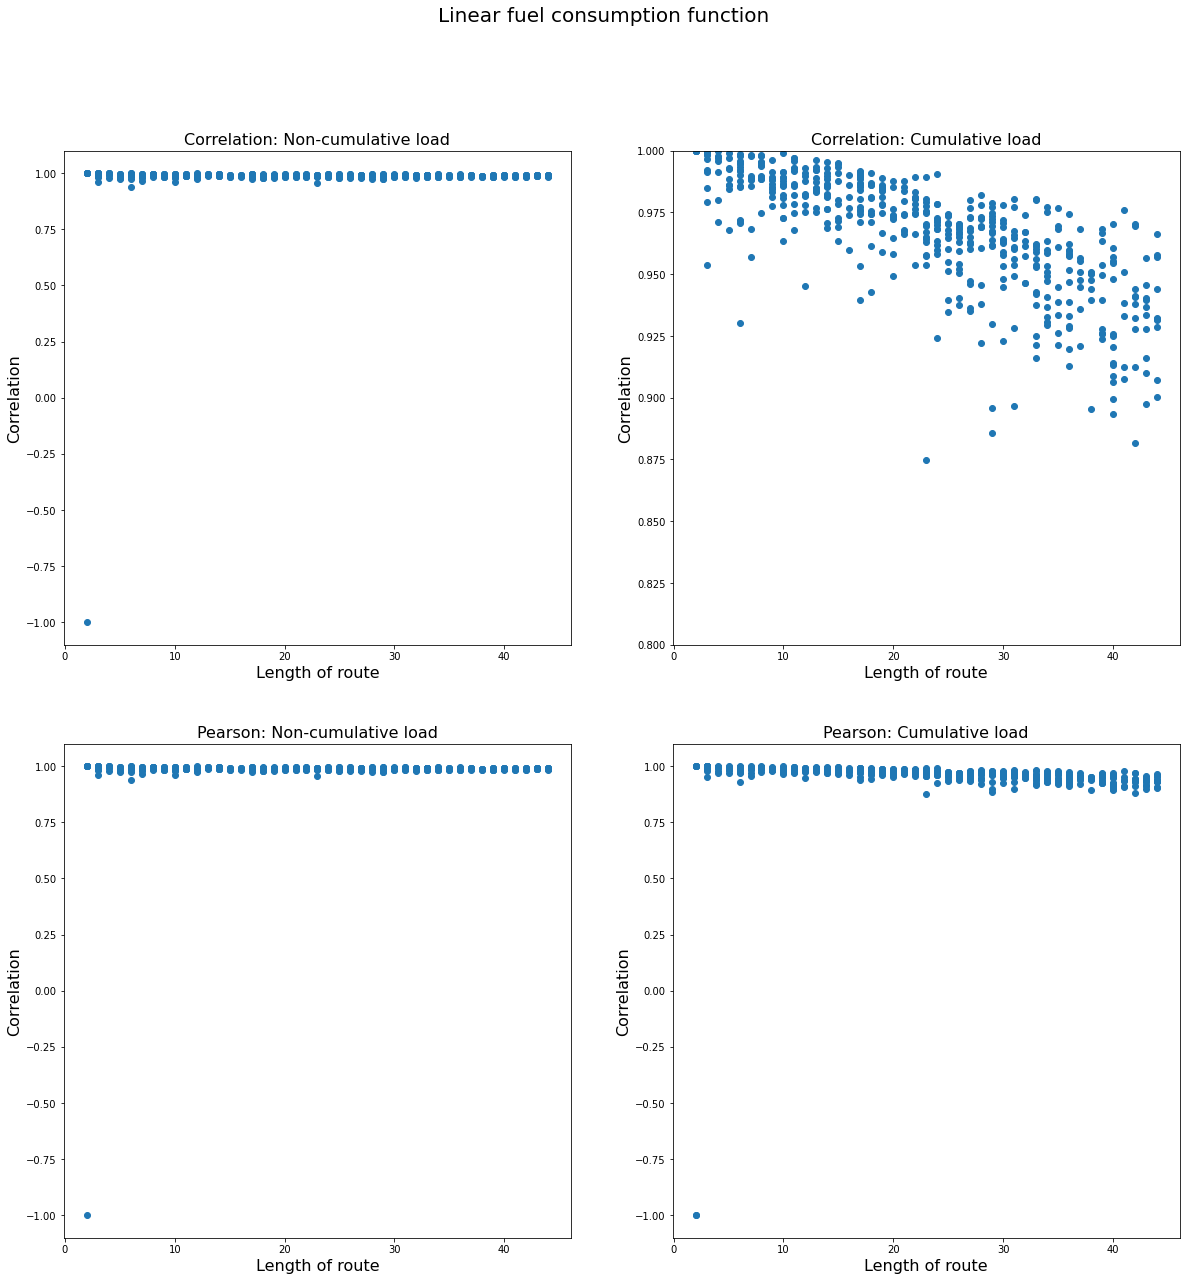

In [88]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

axs[0][0].scatter(np.array(test_distance_linear_correlations)[:,0],np.array(test_distance_linear_correlations)[:,1])
axs[0][0].set_title("Correlation: Non-cumulative load",fontsize=16)
axs[0][0].set_ylabel("Correlation",fontsize=16)
axs[0][0].set_xlabel("Length of route",fontsize=16)
axs[0][1].set_ylim(0.8,1)
axs[0][1].scatter(np.array(test_distance_linear_correlations_cumulative)[:,0],np.array(test_distance_linear_correlations_cumulative)[:,1])
axs[0][1].set_title("Correlation: Cumulative load",fontsize=16)
axs[0][1].set_ylabel("Correlation",fontsize=16)
axs[0][1].set_xlabel("Length of route",fontsize=16)


axs[1][0].scatter(np.array(test_distance_linear_pearson)[:,0],np.array(test_distance_linear_pearson)[:,1])
axs[1][0].set_title("Pearson: Non-cumulative load",fontsize=16)
axs[1][0].set_ylabel("Correlation",fontsize=16)
axs[1][0].set_xlabel("Length of route",fontsize=16)

axs[1][1].scatter(np.array(test_distance_linear_pearson_cumulative)[:,0],np.array(test_distance_linear_pearson_cumulative)[:,1])
axs[1][1].set_title("Pearson: Cumulative load",fontsize=16)
axs[1][1].set_ylabel("Correlation",fontsize=16)
axs[1][1].set_xlabel("Length of route",fontsize=16)

plt.suptitle("Linear fuel consumption function",fontsize=20)
plt.show()